In [71]:
import sys
import ee
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd
from glob import glob
import pprint
import pandas as pd
import numpy as np
import tensorflow as tf
from shapely.geometry import Point, Polygon

sys.path.append('/content')
from src.tools import Mapdisplay,\
    random_point_in_shp
from src.tools import get_bound_points,\
    generate_box_buffer,\
    generate_ee_points,\
    df_to_feature


print('Tensorflow version: ' + tf.__version__)
print('Folium version: ' + folium.__version__)

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'
ee.Initialize()
%load_ext autoreload
%autoreload 2

Tensorflow version: 2.3.0
Folium version: 0.11.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Firstly, we define our prediction area (Camana Valley) and passing to GEE. For moving a vector to GEE, you will use the `ee.Geometry.*` module. The GeoJSON spec describes in detail the type of geometries supported by GEE, including `Point` (a list of coordinates in some projection), `LineString` (a list of points), `LinearRing` (a closed LineString), and Polygon (a list of LinearRings where the first is a shell and subsequent rings are holes). GEE also supports MultiPoint, MultiLineString, and MultiPolygon. The GeoJSON GeometryCollection is also supported, although it has the name MultiGeometry within GEE.

https://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb

In [72]:
datafiles = glob('/datadrive/fia/*.csv')
statebounds = glob('/datadrive/fia/supp_data/stateboundaries/*.shp')[0]
pp = pprint.PrettyPrinter(indent=4,compact=True)
pp.pprint(datafiles)
#subset by STATECD
statecd = pd.read_csv(glob('/datadrive/fia/supp_data/*.csv')[0])
df = gpd.read_file(datafiles[-1])
statecd = pd.read_csv(glob('/datadrive/fia/supp_data/*.csv')[0])
query = 'CA'
states = gpd.read_file(statebounds)
roi = states[states['STPOSTAL']==query]
roi_ee = df_to_feature(roi)
code = statecd[statecd['STATEAB']== query]['STATECD'].values[0]
subdf = df[df['STATECD']==str(code)]
fields = ['PLT_CN', 'INVYR', 'LAT', 'LON']
subdf = subdf.rename(columns={'ACTUAL_LAT':'LAT', 'ACTUAL_LON':'LON'})[fields]
subdf = subdf.astype({'LAT':'float', 'LON':'float', 'INVYR':'int32'})
subdf = gpd.GeoDataFrame(subdf, geometry=gpd.points_from_xy(subdf.LON, subdf.LAT))
subdf = subdf.set_crs(epsg=4326)

[   '/datadrive/fia/NRS_Annualized_Inventory_ActCoordinates_ChangMTA_200413.csv',
    '/datadrive/fia/Chang_2018_MOU_actual_plot_coords.csv',
    '/datadrive/fia/Chang_2018_MOU_actual_plot_coords_run_in_2019.csv',
    '/datadrive/fia/PNWRS_Annualized_Inventory_ActCoordinates_ChangMTA_200731.csv']


In [73]:
#gjson = subdf.to_crs(epsg='4326').iloc[:110].to_json()
xc = np.mean(subdf.LON)
yc = np.mean(subdf.LAT)

mapa = folium.Map(location=[yc, xc],zoom_start=4, tiles='CartoDB dark_matter')

import folium.plugins
marker_cluster = folium.plugins.MarkerCluster().add_to(mapa)
samplesize=999
for point in range(0, len(subdf[:samplesize])):
    folium.Marker(subdf.iloc[point][['LAT','LON']], popup=subdf['PLT_CN'].iloc[point]).add_to(marker_cluster)
#points = folium.features.GeoJson(gjson)

#mapa.add_child(points)
mapa

In [74]:
geometry = [Point(xy) for xy in zip(subdf.LON, subdf.LAT)]
crs = {'init': 'epsg:4326'} #http://www.spatialreference.org/ref/epsg/2263/
geo_df = gpd.GeoDataFrame(subdf.PLT_CN, crs=crs, geometry=geometry)

## here let's think about a way to create a feature collection of the points using first shapely to create a circle around the points and then a rectangular buffer

In [83]:
BUFFER = 120/2
#batch this all out?
BATCHSIZE = 10 
geo_df_batch = geo_df.iloc[:BATCHSIZE]
p = generate_ee_points(geo_df_batch, idname='PLT_CN')
boxes = generate_box_buffer(geo_df_batch, BUFFER, idname='PLT_CN')
fc_boxes = boxes['ee_fc']
box = boxes['box_df']

training_list = fc_boxes.toList(fc_boxes.size())
training_pnts = p.toList(p.size())

In [84]:
training_pnts.getInfo()

[{'type': 'Feature',
  'geometry': {'type': 'Point', 'coordinates': [-120.136011, 36.559327]},
  'id': '0',
  'properties': {'id': '40218205010497'}},
 {'type': 'Feature',
  'geometry': {'type': 'Point', 'coordinates': [-119.854677, 36.589481]},
  'id': '1',
  'properties': {'id': '40218206010497'}},
 {'type': 'Feature',
  'geometry': {'type': 'Point', 'coordinates': [-118.803712, 36.523922]},
  'id': '2',
  'properties': {'id': '40218207010497'}},
 {'type': 'Feature',
  'geometry': {'type': 'Point', 'coordinates': [-118.479162, 36.554354]},
  'id': '3',
  'properties': {'id': '40218208010497'}},
 {'type': 'Feature',
  'geometry': {'type': 'Point', 'coordinates': [-118.359839, 36.502029]},
  'id': '4',
  'properties': {'id': '40218209010497'}},
 {'type': 'Feature',
  'geometry': {'type': 'Point', 'coordinates': [-118.064744, 36.514337]},
  'id': '5',
  'properties': {'id': '40218210010497'}},
 {'type': 'Feature',
  'geometry': {'type': 'Point', 'coordinates': [-116.720226, 36.454237]},

In [85]:
#need to understand the format of these geometries
polyImage = ee.Image(0).byte().paint(fc_boxes, 1).paint(fc_boxes, 2)
polyImage = polyImage.updateMask(polyImage)

mapid = polyImage.getMapId({'min': 1, 'max': 2, 'palette': ['red', 'blue']})

#map_ex = Mapdisplay(center,{'Truckee':truckee.getInfo()},zoom_start=9)
map_ex = folium.Map([39.3175,-120.171],zoom_start=10)
tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(map_ex)
#add points
[folium.Marker((p.geometry.y,p.geometry.x),popup=p.PLT_CN).add_to(map_ex) \
     for _,p in geo_df_batch.iterrows()]
#add boxes
[folium.GeoJson(geom).add_to(map_ex) for geom in box.geometry]
map_ex

In [86]:
# 4.4.3 Prepare the satellite image (Landsat-8)
BANDS = ['R','G','B'] #RGB

naip = ee.ImageCollection("USDA/NAIP/DOQQ")\
               .filterBounds(roi_ee)\
               .filterDate('2007-01-01', '2009-12-31')\
               .select(BANDS).median()
naip2 = ee.ImageCollection("USDA/NAIP/DOQQ")\
               .filterBounds(roi_ee)\
               .filterDate('2017-01-01', '2019-12-31')\
               .select(BANDS).median()
YEAR1 = 2010
YEAR2 = 2020
BAND_YEAR1 = [f'{b}_{YEAR1}' for b in BANDS] 
BAND_YEAR2 = [f'{b}_{YEAR2}' for b in BANDS] 

featureStack = ee.Image.cat([
  naip.select(BANDS).rename(BAND_YEAR1), \
  naip2.select(BANDS).rename(BAND_YEAR2)
]).float()

KERNEL_SIZE = BUFFER*2 
lst = ee.List.repeat(1, KERNEL_SIZE)
lists = ee.List.repeat(lst, KERNEL_SIZE)
kernel = ee.Kernel.fixed(KERNEL_SIZE, KERNEL_SIZE, lists)

arrays = featureStack.neighborhoodToArray(kernel)

EXPORT_BANDS = BAND_YEAR1 + BAND_YEAR2

In [87]:
# INSERT YOUR BUCKET HERE:
BUCKET = 'usfs-fia-data'
# Specify names locations for outputs in Cloud Storage. 
req_no = '002'
FOLDER = f'request-{req_no}'
TRAINING_BASE = 'naip_patches'
SAMPLE = f'{query}_sample_patches'

# Specify inputs (Landsat bands) to the model and the response variable.
opticalBands = ['R','G','B']
BANDS = opticalBands
FEATURES = EXPORT_BANDS 

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 120 
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

# Sizes of the training and evaluation datasets.
TRAIN_SIZE = fc_boxes.size().getInfo()

#EVAL_SIZE = 8000
# Specify model training parameters.
#BATCH_SIZE = 2 
#EPOCHS = 10
#BUFFER_SIZE = 4
#OPTIMIZER = 'SGD'
#LOSS = 'MeanSquaredError'
#METRICS = ['RootMeanSquaredError']

In [88]:
#get one sample from each polygon from the arrays
geomSample = ee.FeatureCollection([])
n = training_pnts.size().getInfo()
for g in range(n):
    sample = arrays.sample(\
                           region = ee.Feature(training_pnts.get(g)).geometry(),\
                           scale = 1,\
                           numPixels = 1,\
                           tileScale=8)
    geomSample = geomSample.merge(sample)
    
desc = TRAINING_BASE + '_g' + str(g)

task = ee.batch.Export.table.toCloudStorage(\
    collection = geomSample,\
    description = desc, \
    bucket = BUCKET,\
    fileNamePrefix = FOLDER + '/' + desc,\
    fileFormat = 'TFRecord',\
    selectors = EXPORT_BANDS)
task.start()

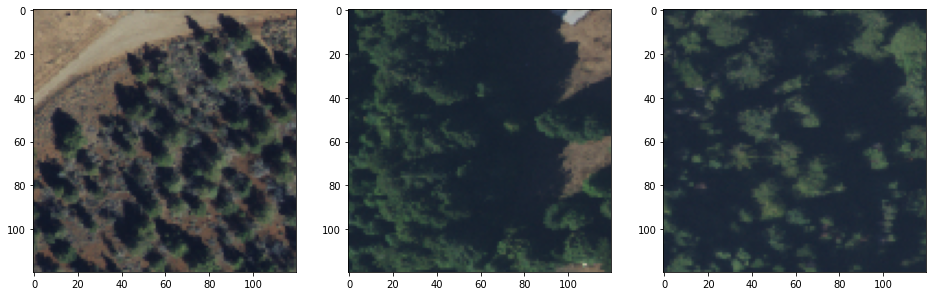

In [92]:
import matplotlib.pyplot as plt

s = geomSample.toList(n)
f, ax = plt.subplots(1,3, figsize=(16,8))
for i in range(3):
    out = s.get(i).getInfo() #get the last image
    r = np.flipud(np.array(out['properties']['R_2020']))
    g = np.flipud(np.array(out['properties']['G_2020']))
    b = np.flipud(np.array(out['properties']['B_2020']))
    rgb = np.array([r,g,b])

    ax[i].imshow(np.moveaxis(rgb, 0,-1))

## Here we would modify the above cell such that our `featureStacks` are separated by years. 

#### For the case of landsat, it would be a feature stack of 84 bands, that is 7 bands for each month aggregated in 3 year periods. Then we would sample from this to get our specificied sample data for training data

#### Need to implement a feature builder from points rather than just sampling randomly from a polygon

In [103]:
tf.io.gfile.glob('gs://usfs-fia-data/*')

PermissionDeniedError: Error executing an HTTP request: HTTP response code 401 with body '{
  "error": {
    "code": 401,
    "message": "Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket.",
    "errors": [
      {
        "message": "Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket.",
        "domain": "global",
        "reason": "required",
        "locationType": "header",
        "location": "Authorization"
      }
    ]
  }
}
'
	 when reading gs://usfs-fia-data/

In [98]:
BUFFER_SIZE = 2 #how many pieces of data to pull out at a time
BATCH_SIZE = 5 #size of sample batch
def parse_tfrecord(example_proto):
  """The parsing function.
  Read a serialized example into the structure defined by FEATURES_DICT.
  Args:
    example_proto: a serialized Example.
  Returns: 
    A dictionary of tensors, keyed by feature name.
  """
  return tf.io.parse_single_example(example_proto, FEATURES_DICT)


def to_tuple(inputs):
  """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
  Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
  Args:
    inputs: A dictionary of tensors, keyed by feature name.
  Returns: 
    A dtuple of (inputs, outputs).
  """
  inputsList = [inputs.get(key) for key in FEATURES]
  stacked = tf.stack(inputsList, axis=0)
  # Convert from CHW to HWC
  stacked = tf.transpose(stacked, [1, 2, 0])
  return stacked[:,:,:len(BANDS)], stacked[:,:,len(BANDS):]


def get_dataset(pattern):
  """Function to read, parse and format to tuple a set of input tfrecord files.
  Get all the files matching the pattern, parse and convert to tuple.
  Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
  Returns: 
    A tf.data.Dataset
  """
  globb = tf.io.gfile.glob(pattern)
  dataset = tf.data.TFRecordDataset(globb, compression_type='GZIP')
  dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  dataset = dataset.map(to_tuple, num_parallel_calls=5)
  return dataset

def get_training_dataset():
    """Get the preprocessed training dataset
    Returns: 
    A tf.data.Dataset of training data.
    """
    globb = 'gs://' + BUCKET + '/' + FOLDER + '/' + TRAINING_BASE + '*'
    dataset = get_dataset(globb)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    return dataset

#def get_eval_dataset():
#    """Get the preprocessed evaluation dataset
#    Returns: 
#    A tf.data.Dataset of evaluation data.
#    """
#    glob = 'gs://' + BUCKET + '/' + FOLDER + '/' + EVAL_BASE + '*'
#    dataset = get_dataset(glob)
#    dataset = dataset.batch(1).repeat()
#    return dataset

#evaluation = get_eval_dataset()

training = get_training_dataset()

#print(iter(training.take(1)).next())

PermissionDeniedError: Error executing an HTTP request: HTTP response code 401 with body '{
  "error": {
    "code": 401,
    "message": "Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket.",
    "errors": [
      {
        "message": "Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket.",
        "domain": "global",
        "reason": "required",
        "locationType": "header",
        "location": "Authorization"
      }
    ]
  }
}
'
	 when reading gs://usfs-fia-data/request-002

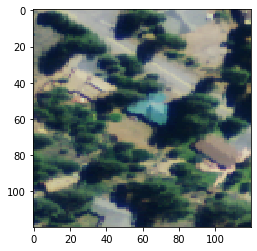

In [422]:
t = iter(training.take(2)).next()
imgs = t[0].numpy()
plt.imshow(imgs[0,:,:,:]/255)

In [423]:
#looks good. Package it up and repeat this process for the other variables.